# Auto-encoders

Autoencoders are neural networks that learn to efficiently compress and encode data then learn to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible. Therefore, autoencoders reduce the dimentsionality of the input data i.e. reducing the number of features that describe input data.

They are popular for data denoising, feature extractions.

<center><img src="figures/autoen_architecture.png" alt="cnn" style="width: 800px;"/></center>
The architecture of auto-encoders are typically symmetrical: the decoder and encoder blocks are neural networks that can contain convolutional layers, recurrent networks, dense networks etc. The core part of the network, the **bottleneck** contains the fewest features that best represent the input.


Find interesting overview of several canonical architectures of auto-encoders:
https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import sklearn
from sklearn.model_selection import train_test_split
from keras import layers


import torch
import torch.nn as nn


In [20]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
class_names = ["tshirt","trousers","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
X_val,X_train = X_train_full[:5000]/255.0,X_train_full[5000:]/255.0
y_val,y_train = y_train_full[:5000],y_train_full[5000:]
# Here we have to add one dimension to the images in order to match the conv2D requirements in Keras.
# And we do it for all variables.
# X_train=X_train[...,None]
# X_val=X_val[...,None]
# X_test=X_test[...,None]
print(X_train.shape)
print(y_train.shape)
print(np.unique(y_train))
print(len(np.unique(y_train)))

(55000, 28, 28)
(55000,)
[0 1 2 3 4 5 6 7 8 9]
10


In [25]:
stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100,activation="selu"),
    keras.layers.Dense(30,activation="selu")
],name='encoder')
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100,activation="selu",input_shape=[30]),
    keras.layers.Dense(28*28,activation="sigmoid"),
    keras.layers.Reshape([28,28])
],name='decoder')

stacked_ae = keras.models.Sequential([stacked_encoder,stacked_decoder])
stacked_ae.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 30)                81530     
_________________________________________________________________
decoder (Sequential)         (None, 28, 28)            82284     
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
_________________________________________________________________


The loss function in this case is noto a MSE but instead a multilabel binary classifier on the propability of the pixel. Model conveerse

In [26]:
stacked_ae.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5))

In [29]:
history = stacked_ae.fit(X_train,X_train,epochs=10,validation_data=(X_val,X_val))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3046 - val_loss: 0.2977
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2981 - val_loss: 0.2928
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2940 - val_loss: 0.2935
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2911 - val_loss: 0.2864
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2891 - val_loss: 0.2867
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2877 - val_loss: 0.2838
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2866 - val_loss: 0.2847
Epoch 8/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2857 - val_loss: 0.2820
Epoch 9/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2849 - val_loss: 0.2812
Epoch 10/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.284

We can visualize the reconstruction images.

In [39]:
def plot_image(image):
    plt.imshow(image,cmap="binary")
    plt.axis("off")
    
def show_reconstruction(model,n_images=5):
    reconstruction=model.predict(X_val[:n_images])
    for image_index in range(n_images):
        plt.subplot(2,n_images,1+image_index)
        plot_image(X_val[image_index])
        plt.subplot(2,n_images,1+n_images+image_index)
        plot_image(reconstruction[image_index])

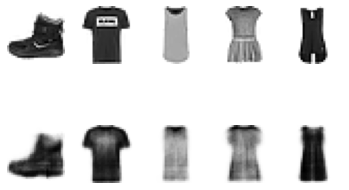

In [40]:
show_reconstruction(stacked_ae)

This is not bad, but not great either. One could imagine training for longer or changing the architecture to include more layers or convolutional layers.

## visualization of the features
The number of features in the bottleneck are a lower dimension representation of the input data. It is common practice to attempt to visualize the features at this stage. Visualization may require further dimensionality reduction such as PCA.

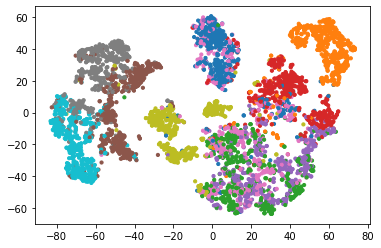

In [45]:
from sklearn.manifold import TSNE
X_val_compressed = stacked_encoder.predict(X_val)
tsne=TSNE()
X_val_2d=tsne.fit_transform(X_val_compressed)
plt.scatter(X_val_2d[:,0],X_val_2d[:,1],c=y_val,s=10,cmap="tab10")

# Convolutional autoencoder


In [58]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28,28,1],input_shape=[28,28]),
    keras.layers.Conv2D(16,kernel_size=3,padding="same",activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32,kernel_size=3,padding="same",activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64,kernel_size=3,padding="same",activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
],name='encoder_cnn')
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32,kernel_size=3,padding="valid",strides=2,activation="selu",input_shape=[3,3,64]),
    keras.layers.Conv2DTranspose(16,kernel_size=3,padding="same",strides=2,activation="selu"),
    keras.layers.Conv2DTranspose(1,kernel_size=3,padding="same",strides=2,activation="sigmoid"),
    keras.layers.Reshape([28,28])
],name='decoder_cnn')

stacked_ae_cnn = keras.models.Sequential([conv_encoder,conv_decoder])
stacked_ae_cnn.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_cnn (Sequential)     (None, 3, 3, 64)          23296     
_________________________________________________________________
decoder_cnn (Sequential)     (None, 28, 28)            23233     
Total params: 46,529
Trainable params: 46,529
Non-trainable params: 0
_________________________________________________________________


In [59]:
stacked_ae_cnn.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5))

In [60]:
history = stacked_ae_cnn.fit(X_train,X_train,epochs=20,validation_data=(X_val,X_val))

Epoch 1/20
1719/1719 [==============================] - 25s 14ms/step - loss: 0.3274 - val_loss: 0.2763
Epoch 2/20
1719/1719 [==============================] - 25s 15ms/step - loss: 0.2755 - val_loss: 0.2672
Epoch 3/20
1719/1719 [==============================] - 25s 15ms/step - loss: 0.2703 - val_loss: 0.2650
Epoch 4/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2681 - val_loss: 0.2627
Epoch 5/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.2658 - val_loss: 0.2636
Epoch 6/20
1719/1719 [==============================] - 25s 15ms/step - loss: 0.2644 - val_loss: 0.2609
Epoch 7/20
1719/1719 [==============================] - 25s 14ms/step - loss: 0.2639 - val_loss: 0.2617
Epoch 8/20
1719/1719 [==============================] - 25s 15ms/step - loss: 0.2626 - val_loss: 0.2585
Epoch 9/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2621 - val_loss: 0.2581
Epoch 10/20
1719/1719 [==============================] - 25s 15m

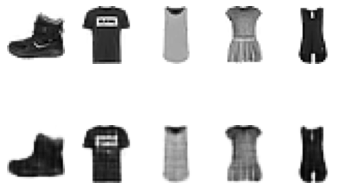

In [61]:
show_reconstruction(stacked_ae_cnn)

#  Denoising auto-encoder

Instead of training on the same input and ouput data, we can train a noisy data to represent a clean data.
<center><img src="figures/denoising-autoencoder-architecture.png" alt="cnn" style="width: 800px;"/></center>

When starting with noise-free data, there are two ways to implement a denoising algorithm. First, one add noise to the data. Keras has a built in layer called GaussianNoise, but it would be easily implemented by adding a more structured noise to the data (use domain-knowledge). Second, one can use DropOut layer.

In [65]:
denoise_encoder = keras.models.Sequential([
    keras.layers.Reshape([28,28,1],input_shape=[28,28]),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(16,kernel_size=3,padding="same",activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32,kernel_size=3,padding="same",activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64,kernel_size=3,padding="same",activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
],name='encoder_cnn')
denoise_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32,kernel_size=3,padding="valid",strides=2,activation="selu",input_shape=[3,3,64]),
    keras.layers.Conv2DTranspose(16,kernel_size=3,padding="same",strides=2,activation="selu"),
    keras.layers.Conv2DTranspose(1,kernel_size=3,padding="same",strides=2,activation="sigmoid"),
    keras.layers.Reshape([28,28])
],name='decoder_cnn')

denoise_ae_cnn = keras.models.Sequential([conv_encoder,conv_decoder])
denoise_ae_cnn.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_cnn (Sequential)     (None, 3, 3, 64)          23296     
_________________________________________________________________
decoder_cnn (Sequential)     (None, 28, 28)            23233     
Total params: 46,529
Trainable params: 46,529
Non-trainable params: 0
_________________________________________________________________


In [68]:
denoise_ae_cnn.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5))
history = denoise_ae_cnn.fit(X_train,X_train,epochs=20,validation_data=(X_val,X_val))

Epoch 1/20
1719/1719 [==============================] - 25s 14ms/step - loss: 0.2551 - val_loss: 0.2533
Epoch 2/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2565 - val_loss: 0.2543
Epoch 3/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2554 - val_loss: 0.2525
Epoch 4/20
1719/1719 [==============================] - 25s 14ms/step - loss: 0.2551 - val_loss: 0.2531
Epoch 5/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2557 - val_loss: 0.2524
Epoch 6/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.2550 - val_loss: 0.2526
Epoch 7/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2552 - val_loss: 0.2539
Epoch 8/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2549 - val_loss: 0.2521
Epoch 9/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2558 - val_loss: 0.2527
Epoch 10/20
1719/1719 [==============================] - 25s 15m

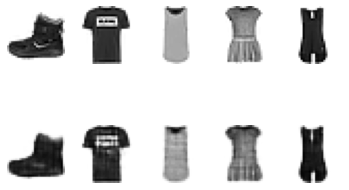

In [67]:
show_reconstruction(denoise_ae_cnn)

# Example in seismology 

The DeepDenoiser is an interesting architecture to remove noise from seismograms

<center><img src="figures/DeepDenoiser_architecture.png" alt="cnn" style="width: 800px;"/></center>
<center>Architecture of the DeepDenoiser Zhu et al, 2019: </center>
The input is 2 images of the real and imaginary part of the short time Fourier transform of a seismogram. The ouputs are 2 masks to apply on the data to extract the noise and the clean signal tiime series.

You will note that the auto-encoder has skip connections. These have shown to improve training convergence and performance. They break the sequence of the neural networks, therefore we to need to introduce wide neural networks! Stay tuned as I update this tutorial.

Example of denoising seismogram is shown below.


<center><img src="figures/DeepDenoiser_example.png" alt="cnn" style="width: 800px;"/></center>
<center>Example of the DeepDenoiser Zhu et al, 2019: </center>

Now as an exercise, try it ou!

# Variational Auto-encoders

